Let's put all the pieces together, and train a model:

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

First, we'll need training and test datasets. If you haven't already, run the cell below to make sure the dataset is downloaded. (It may take a minute.)

In [22]:
BATCH_SIZE = 16
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomCrop(32,padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.SVHN(root='./data', split='train',
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_with_rejection = classes + ('UNKNOWN',)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


We'll run our check on the output from `DataLoader`:

         4          4          1          2          2          4          3          2
         7          6          8          5          1          2          9          6


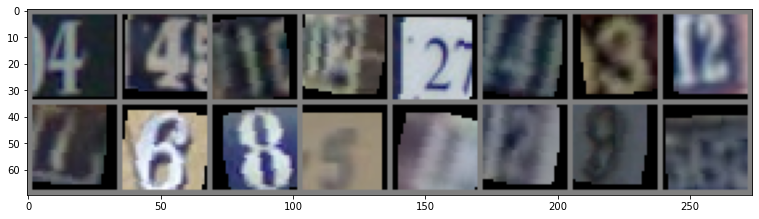

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (13,13))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [24]:
import sys 
sys.path.append('..')
use_cuda = torch.cuda.is_available()
print("use_cuda", use_cuda)

use_cuda True


In [25]:
model_path = "svhn.pth"
model = torch.load(model_path)
if use_cuda: model = model.cuda()

In [26]:
class SelfAdativeTraining():
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        # if not inited, use onehot label to initialize runnning vector
        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)

        # momentum update
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)

In [27]:
criterion = SelfAdativeTraining(num_examples=len(trainset), num_classes=len(classes), mom=.99)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9, weight_decay=5e-4)

In [28]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

True labels
         2          4          7          3          2          2          8          3
         4          5          9          1          1          1          1          3
Predicted labels
         2          4          7          3          2          2          8          3
         4          5          9          1          1          1          1    UNKNOWN


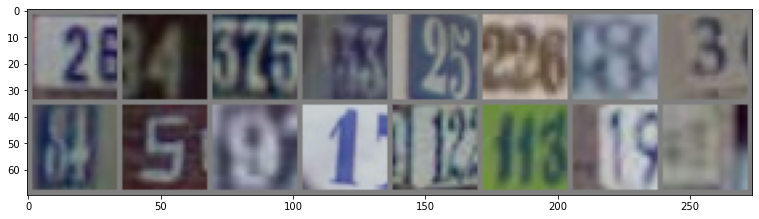

In [96]:
# get some random training images
found_doubt = False
dataiter = iter(testloader)
while found_doubt == False:
    images, labels = dataiter.next()
    initial_outputs = model(images).cpu()
    values, predictions = initial_outputs.data.max(1)
    outputs = F.softmax(initial_outputs, dim=1)
    reservation = outputs[:,-1]
    found_doubt = np.any(np.argmax(outputs.detach().numpy(), axis=1) == 10)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("True labels")
print(' '.join('%10s' % classes[labels[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))
print("Predicted labels")
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(0 , BATCH_SIZE//2)))
print(' '.join('%10s' % classes_with_rejection[predictions[j]] for j in range(BATCH_SIZE//2 , BATCH_SIZE)))

In [97]:
print("Values", values)
print("predictions indices", np.where(predictions == 10))
print("predictions", values[predictions == 10])
print("Probs")
print(classes_with_rejection)
print(outputs[np.where(predictions == 10)].detach().numpy())

Values tensor([6.7885, 6.9907, 6.8124, 6.9848, 6.8444, 6.7197, 6.7021, 6.9582, 6.8465,
        6.7307, 6.8816, 7.0941, 6.9625, 7.1631, 7.0106, 4.0672])
predictions indices (array([15]),)
predictions tensor([4.0672])
Probs
('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'UNKNOWN')
[[0.002 0.268 0.165 0.021 0.003 0.001 0.001 0.003 0.004 0.002 0.529]]


No misclassification found

In [98]:
# print("Misclassifications", np.where(predictions.eq(labels.data).numpy() == False))
# print("Probs of misclassification")
# print(classes_with_rejection)
# print(outputs[np.where(predictions.eq(labels.data).numpy() == False)].detach().numpy())

In [99]:
print(reservation.detach().numpy() )

[0.142 0.155 0.176 0.18  0.186 0.143 0.19  0.153 0.161 0.16  0.159 0.13
 0.154 0.125 0.15  0.529]


In [100]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[k-1].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
abstention_results = []
top1 = AverageMeter()
top5 = AverageMeter()
generator = iter(testloader)
print("Total batches ", len(generator))
for batch_idx in range(len(generator)):
    batch_data = next(generator)
    inputs, labels = batch_data
    
    if use_cuda:
        inputs = inputs.cuda()
    inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

    with torch.no_grad():
        outputs = model(inputs).cpu()
        values, predictions = outputs.data.max(1)
        outputs = F.softmax(outputs, dim=1)
        outputs, reservation = outputs[:,:-1], outputs[:,-1]
        print("Batch: ", batch_idx)
        abstention_result = list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))
        print(abstention_result)
        abstention_results.extend(abstention_result)
        prec1, prec5 = accuracy(outputs.data, labels.data, topk=(1, 5))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))
    
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))

Total batches  4579
Batch:  0
[(0.15311581, True), (0.1401907, True), (0.14270426, True), (0.1571374, True), (0.15347165, True), (0.23407435, True), (0.14888267, True), (0.14649872, True), (0.16506745, True), (0.1507812, True), (0.14693846, True), (0.17554142, True), (0.36884522, True), (0.16452286, True), (0.14203593, True), (0.15708046, True)]
Batch:  1
[(0.15850382, True), (0.15281579, True), (0.13692604, True), (0.16496418, True), (0.2058504, True), (0.1622505, True), (0.170711, True), (0.16016932, True), (0.15239456, True), (0.15645355, True), (0.16002508, True), (0.15996507, True), (0.15995519, True), (0.1733194, True), (0.1608132, True), (0.14268313, True)]
Batch:  2
[(0.12857382, True), (0.17452942, True), (0.13559532, True), (0.15355912, True), (0.16063616, True), (0.15661728, True), (0.16924386, True), (0.14498892, True), (0.13507847, True), (0.1853451, True), (0.15062208, True), (0.15279528, True), (0.20873787, True), (0.1922143, True), (0.15610601, True), (0.17955774, True)

Batch:  25
[(0.5025654, False), (0.15064903, True), (0.16392171, True), (0.15025137, True), (0.1514087, True), (0.13557981, True), (0.16085672, True), (0.14528006, True), (0.15557268, True), (0.15123743, True), (0.15620513, True), (0.15721022, True), (0.13429281, True), (0.1500859, True), (0.15320157, True), (0.15201361, True)]
Batch:  26
[(0.15175255, True), (0.16694169, True), (0.12181582, True), (0.2681814, True), (0.14287518, True), (0.2583623, True), (0.15798573, True), (0.15106043, True), (0.15366821, True), (0.15384743, True), (0.1384756, False), (0.14910187, True), (0.14323264, True), (0.12527773, True), (0.1439302, True), (0.15439565, True)]
Batch:  27
[(0.15985794, True), (0.15017423, True), (0.14740276, True), (0.15707915, True), (0.14238492, True), (0.18905394, True), (0.1478277, True), (0.17909263, True), (0.15969524, True), (0.14735615, True), (0.17633949, True), (0.15154462, True), (0.15268509, True), (0.14664888, True), (0.17067781, True), (0.1608356, True)]
Batch:  28


Batch:  52
[(0.2012498, True), (0.17153883, True), (0.14482526, True), (0.14797218, True), (0.16111735, True), (0.15479456, True), (0.15650567, True), (0.15428151, True), (0.22244091, True), (0.12410128, True), (0.14752847, True), (0.16182855, True), (0.16543259, True), (0.15922403, True), (0.1548121, True), (0.15334482, True)]
Batch:  53
[(0.15311481, True), (0.1540829, True), (0.15594476, True), (0.1627196, True), (0.18594974, True), (0.2007817, True), (0.15058638, True), (0.14520004, True), (0.14616762, True), (0.14916101, True), (0.15851139, True), (0.1604711, True), (0.12880264, True), (0.1369326, True), (0.16327225, True), (0.1770841, True)]
Batch:  54
[(0.14266123, True), (0.14220054, True), (0.1515836, True), (0.22153169, True), (0.14544617, True), (0.18182975, True), (0.16396038, True), (0.15433434, True), (0.1641077, True), (0.14396599, True), (0.13307063, True), (0.15476395, True), (0.1290294, True), (0.16081466, True), (0.15624788, True), (0.15439384, True)]
Batch:  55
[(0.

Batch:  82
[(0.15701792, True), (0.16177744, True), (0.15448909, True), (0.15667556, True), (0.14302795, True), (0.12096894, True), (0.13227642, True), (0.15798217, True), (0.13587777, True), (0.14415085, True), (0.15956306, True), (0.15829742, True), (0.15094523, True), (0.1297028, True), (0.13379434, True), (0.14703864, True)]
Batch:  83
[(0.15754315, True), (0.1911716, True), (0.15358439, True), (0.15581492, True), (0.16841248, True), (0.14329717, True), (0.14979836, True), (0.17043494, True), (0.15529911, True), (0.15358329, True), (0.1511782, True), (0.15590394, True), (0.15400948, True), (0.14402261, True), (0.13908973, True), (0.13615209, True)]
Batch:  84
[(0.13659632, True), (0.16167234, True), (0.14580108, True), (0.1555495, True), (0.15605474, True), (0.14956464, True), (0.16641177, True), (0.15553282, True), (0.14488609, True), (0.15547186, True), (0.15993184, True), (0.16738907, True), (0.162712, True), (0.15443787, True), (0.15948701, True), (0.1637529, True)]
Batch:  85


Batch:  112
[(0.27582523, True), (0.16321474, True), (0.1501311, True), (0.16843039, True), (0.13452087, True), (0.16051073, True), (0.15923028, True), (0.15515652, True), (0.152814, True), (0.13347213, True), (0.15430893, True), (0.15686648, True), (0.15889227, True), (0.1603132, True), (0.15997863, True), (0.14593399, True)]
Batch:  113
[(0.15581754, True), (0.15375109, True), (0.1488669, True), (0.15526824, True), (0.16768953, True), (0.15188262, True), (0.15705952, True), (0.15250066, True), (0.15795143, True), (0.19525388, True), (0.16091126, True), (0.25246632, True), (0.1481974, True), (0.15860368, True), (0.15548964, True), (0.14937186, True)]
Batch:  114
[(0.15658252, True), (0.15332969, True), (0.12115276, True), (0.16056219, True), (0.34123266, False), (0.17069377, True), (0.15384671, True), (0.14668839, True), (0.15537508, True), (0.16448209, True), (0.14764684, True), (0.1251992, True), (0.15546943, True), (0.1447828, True), (0.16305377, True), (0.15302223, True)]
Batch:  

Batch:  140
[(0.16870674, True), (0.16616765, True), (0.14694656, True), (0.15861426, True), (0.31126577, True), (0.13632016, True), (0.1721218, True), (0.15858798, True), (0.14278239, True), (0.16026315, True), (0.14573163, True), (0.15462889, True), (0.16857515, True), (0.18126865, True), (0.15517803, True), (0.14513153, True)]
Batch:  141
[(0.15072204, True), (0.15852262, True), (0.16522175, True), (0.14487438, True), (0.15819596, True), (0.12602393, True), (0.16658469, True), (0.15868172, True), (0.15189141, True), (0.15825002, True), (0.1541544, True), (0.17300257, True), (0.158565, True), (0.17268983, True), (0.16273461, True), (0.1698742, True)]
Batch:  142
[(0.24448049, True), (0.1279684, True), (0.16404797, True), (0.16082552, True), (0.15272117, True), (0.15474397, True), (0.1567737, True), (0.15435621, True), (0.16061993, True), (0.15376347, True), (0.1636163, True), (0.15696618, True), (0.16016111, True), (0.16298686, True), (0.15007842, True), (0.1545767, True)]
Batch:  14

Batch:  169
[(0.16501813, True), (0.16260345, True), (0.21406317, True), (0.15950048, True), (0.16208231, True), (0.16532426, True), (0.15531121, True), (0.15265006, True), (0.16233958, True), (0.15472502, True), (0.15463199, True), (0.13077088, True), (0.22902201, True), (0.13105565, True), (0.18134634, True), (0.15385431, True)]
Batch:  170
[(0.13182823, True), (0.15155625, True), (0.15356572, True), (0.14816952, True), (0.15578118, True), (0.17375188, True), (0.16524115, True), (0.16286297, True), (0.15901318, True), (0.13756981, True), (0.15094137, True), (0.15255585, True), (0.16992374, True), (0.15507358, True), (0.13027756, True), (0.15861021, True)]
Batch:  171
[(0.20122322, True), (0.30072638, True), (0.1546163, True), (0.15050259, True), (0.14479923, True), (0.15834534, True), (0.27080837, True), (0.14154685, True), (0.17117578, True), (0.15808234, True), (0.16155365, True), (0.14960003, True), (0.32503554, True), (0.16375019, True), (0.18729682, True), (0.14268424, True)]
Ba

Batch:  199
[(0.1545529, True), (0.16026275, True), (0.15716855, True), (0.1485915, True), (0.16840021, True), (0.23587808, True), (0.16575095, True), (0.14199905, True), (0.1566105, True), (0.15013492, True), (0.16013882, True), (0.14245224, True), (0.18684284, True), (0.1590368, True), (0.5453044, False), (0.15621348, True)]
Batch:  200
[(0.13240042, True), (0.16213503, True), (0.16985264, True), (0.17014085, True), (0.15289651, True), (0.15089528, True), (0.27398345, False), (0.15154895, True), (0.14161089, True), (0.18377583, True), (0.1310723, True), (0.15227339, True), (0.152441, True), (0.16696478, True), (0.12886523, True), (0.14838831, True)]
Batch:  201
[(0.14778152, True), (0.25372392, True), (0.13060239, True), (0.1313719, True), (0.17441216, True), (0.14307566, True), (0.24229968, True), (0.15300268, True), (0.15956114, True), (0.16720115, True), (0.15200208, True), (0.13643895, True), (0.15286995, True), (0.15616843, True), (0.16131383, True), (0.1514069, True)]
Batch:  2

Batch:  229
[(0.15351325, True), (0.16311225, True), (0.14850311, True), (0.15128548, True), (0.16298336, True), (0.16318992, True), (0.16697249, True), (0.20674735, True), (0.13238543, True), (0.125511, True), (0.14568551, True), (0.121010005, True), (0.15964359, True), (0.17796583, True), (0.12921612, True), (0.1521012, True)]
Batch:  230
[(0.27751657, True), (0.14319797, True), (0.16944721, True), (0.16764806, True), (0.14144348, True), (0.15764159, True), (0.15760441, True), (0.15797435, True), (0.1576157, True), (0.14566992, True), (0.13571613, True), (0.14467037, True), (0.15969042, True), (0.15406333, True), (0.18902895, True), (0.1529475, True)]
Batch:  231
[(0.18915065, True), (0.1460488, True), (0.51121736, False), (0.15439105, True), (0.17961098, True), (0.15932737, True), (0.15122116, True), (0.13632682, True), (0.13951103, True), (0.20868851, True), (0.15993787, True), (0.15730843, True), (0.16785033, True), (0.14227358, True), (0.16092317, True), (0.2982897, True)]
Batch:

Batch:  259
[(0.16516656, True), (0.15617262, True), (0.15112114, True), (0.18033448, True), (0.13450393, True), (0.15950456, True), (0.16479133, True), (0.16311826, True), (0.13406171, True), (0.17789763, True), (0.14473891, True), (0.15011643, True), (0.1578471, True), (0.15746905, True), (0.15882765, True), (0.16732053, True)]
Batch:  260
[(0.16096133, True), (0.14906947, True), (0.15575224, True), (0.14383344, True), (0.1277234, True), (0.14520647, True), (0.14445107, True), (0.15618679, True), (0.29978508, True), (0.15717414, True), (0.15613392, True), (0.14157294, True), (0.15787107, True), (0.16331236, True), (0.16306871, True), (0.15329689, True)]
Batch:  261
[(0.15405378, True), (0.1551736, True), (0.15004417, True), (0.159586, True), (0.14673544, True), (0.16091542, True), (0.15209186, True), (0.14407189, True), (0.1618823, True), (0.15183423, True), (0.14914225, True), (0.15354759, True), (0.14851585, True), (0.1577191, True), (0.12638263, True), (0.1639087, True)]
Batch:  2

Batch:  289
[(0.14102407, True), (0.15570469, True), (0.14640066, True), (0.22437494, True), (0.15903778, True), (0.14248677, True), (0.12987745, True), (0.13828264, True), (0.15896268, True), (0.13673945, True), (0.22322486, True), (0.1415534, True), (0.15947846, True), (0.1584959, True), (0.15386817, True), (0.15972283, True)]
Batch:  290
[(0.1689512, True), (0.1586269, True), (0.1915263, True), (0.14313477, True), (0.14228645, True), (0.14003356, True), (0.1586285, True), (0.1508844, True), (0.16282827, True), (0.17796935, True), (0.14504723, True), (0.1646652, True), (0.14733024, True), (0.36638257, True), (0.1281934, True), (0.16306573, True)]
Batch:  291
[(0.16628186, True), (0.12312902, True), (0.14507626, True), (0.13476156, True), (0.15356977, True), (0.15148981, True), (0.15648611, True), (0.30440935, True), (0.14015326, True), (0.16023552, True), (0.16185474, True), (0.16087079, True), (0.14572294, True), (0.15890127, True), (0.1561792, True), (0.2756258, True)]
Batch:  292


Batch:  316
[(0.16326265, True), (0.13576022, True), (0.15944037, True), (0.14450997, True), (0.15462254, True), (0.15775983, True), (0.17168035, True), (0.1728892, True), (0.15447915, True), (0.1467185, True), (0.16566111, True), (0.1583112, True), (0.154073, True), (0.15752123, True), (0.123778, True), (0.12614928, True)]
Batch:  317
[(0.1285571, True), (0.16357619, False), (0.14427638, True), (0.14897172, True), (0.16790825, True), (0.15656061, True), (0.1430969, True), (0.15479982, True), (0.1627415, True), (0.15194927, True), (0.1459464, True), (0.15479843, True), (0.16009994, True), (0.160209, True), (0.15775716, True), (0.15135472, True)]
Batch:  318
[(0.15329534, True), (0.14209522, True), (0.15356287, True), (0.13070807, True), (0.16860303, True), (0.15658325, True), (0.1535638, True), (0.15815914, True), (0.16357855, True), (0.15881997, True), (0.15163828, True), (0.18459113, True), (0.15778889, True), (0.16001724, True), (0.155084, True), (0.15466401, True)]
Batch:  319
[(0.

Batch:  342
[(0.12605684, True), (0.16281807, True), (0.15507011, True), (0.3593758, True), (0.18365845, True), (0.16332439, True), (0.15051119, True), (0.14413616, True), (0.15423508, True), (0.15826917, True), (0.12992853, True), (0.15296733, True), (0.1592041, True), (0.16630389, True), (0.12876017, True), (0.24414846, True)]
Batch:  343
[(0.18107302, True), (0.15830536, True), (0.37193528, True), (0.14171773, True), (0.15490401, True), (0.15247007, True), (0.15919115, True), (0.16572285, True), (0.14850403, True), (0.15569991, True), (0.14640102, True), (0.16092846, True), (0.13118003, True), (0.19285116, True), (0.19522546, True), (0.17848891, True)]
Batch:  344
[(0.1733555, True), (0.16095592, True), (0.14768678, True), (0.15129562, True), (0.15553866, True), (0.16665955, True), (0.12448585, True), (0.1594499, True), (0.36390847, True), (0.18824384, True), (0.15019487, True), (0.16070756, True), (0.16442603, True), (0.14872332, True), (0.26169664, True), (0.1434953, True)]
Batch:

Batch:  369
[(0.15843135, True), (0.14775035, True), (0.14564568, True), (0.15991399, True), (0.15173635, True), (0.15840146, True), (0.12797865, True), (0.15847258, True), (0.15357476, True), (0.1543976, True), (0.17682686, True), (0.16195102, True), (0.16495222, True), (0.15364222, True), (0.16272217, True), (0.22491062, True)]
Batch:  370
[(0.17605978, True), (0.17113817, True), (0.16149268, True), (0.15837426, True), (0.15848175, True), (0.1595246, True), (0.12702775, True), (0.16496663, True), (0.1589223, True), (0.1230138, True), (0.14561279, True), (0.16975585, True), (0.16406494, True), (0.19041534, True), (0.15964486, True), (0.15283436, True)]
Batch:  371
[(0.124594666, True), (0.15457073, True), (0.12941039, True), (0.17836873, False), (0.15506311, True), (0.15961963, True), (0.1517113, True), (0.1563549, True), (0.16410397, True), (0.12839362, True), (0.15712017, True), (0.185796, True), (0.16486867, True), (0.16493323, True), (0.16209301, True), (0.16128653, True)]
Batch: 

Batch:  397
[(0.12367509, True), (0.15521319, True), (0.12831077, True), (0.16674244, True), (0.16430137, True), (0.1516993, True), (0.16179426, True), (0.16321123, True), (0.1497713, True), (0.15895274, True), (0.15204541, True), (0.15441187, True), (0.15948434, True), (0.17080489, True), (0.16267045, True), (0.1467185, True)]
Batch:  398
[(0.15802151, True), (0.16741969, True), (0.14952074, True), (0.16207597, True), (0.15119088, True), (0.14607286, True), (0.14436041, True), (0.13255253, True), (0.17781518, True), (0.16257274, True), (0.25359333, True), (0.14060314, True), (0.15626398, True), (0.13946767, True), (0.14405929, True), (0.14940637, True)]
Batch:  399
[(0.14379139, True), (0.14645664, True), (0.14197102, True), (0.14710459, True), (0.15297621, True), (0.1524047, True), (0.15403917, True), (0.1642536, True), (0.15439567, True), (0.15873331, True), (0.1563917, True), (0.1461131, True), (0.16308069, True), (0.15896048, True), (0.15630935, True), (0.18155913, True)]
Batch:  

Batch:  423
[(0.16178852, True), (0.16213769, True), (0.16978727, True), (0.16382566, True), (0.14380097, True), (0.15471303, True), (0.16072613, True), (0.14591978, True), (0.17024839, True), (0.1541801, True), (0.14887747, True), (0.14528413, True), (0.15885389, True), (0.14745855, True), (0.15375708, True), (0.15669347, True)]
Batch:  424
[(0.24783072, True), (0.22093889, True), (0.15506338, True), (0.15368545, True), (0.15993823, True), (0.15849581, True), (0.16056359, True), (0.21923836, True), (0.16001788, True), (0.15369157, True), (0.16401052, True), (0.1534963, True), (0.20872076, True), (0.15763152, True), (0.1470422, True), (0.17380853, True)]
Batch:  425
[(0.15586558, True), (0.15329204, True), (0.15823758, True), (0.1303978, True), (0.16734666, True), (0.13258831, True), (0.13056166, True), (0.14059846, True), (0.21319054, True), (0.15182541, True), (0.16142756, True), (0.15216258, True), (0.12820776, True), (0.16150242, True), (0.13538477, True), (0.13623057, True)]
Batch

Batch:  450
[(0.16142109, True), (0.17556654, True), (0.14476869, True), (0.15995328, True), (0.16521317, True), (0.14252594, True), (0.5686068, False), (0.15509403, True), (0.15424271, True), (0.13056429, True), (0.16155882, True), (0.15262127, True), (0.19337378, True), (0.14951557, True), (0.14115079, True), (0.15325262, True)]
Batch:  451
[(0.15237601, True), (0.48139864, False), (0.16147579, True), (0.1536322, True), (0.26842242, True), (0.16861232, True), (0.126703, True), (0.1552446, True), (0.1580975, True), (0.14757738, True), (0.15041822, True), (0.21270907, True), (0.1579249, True), (0.16047142, True), (0.12821557, True), (0.16077663, True)]
Batch:  452
[(0.15683733, True), (0.16873005, True), (0.15497576, True), (0.13627076, True), (0.16385396, True), (0.14298204, True), (0.16000497, True), (0.15662691, True), (0.15124094, True), (0.15017419, True), (0.16632462, True), (0.12760545, True), (0.15696023, True), (0.122627735, True), (0.15966618, True), (0.15871757, True)]
Batch

Batch:  476
[(0.15922605, True), (0.1501428, True), (0.14980187, True), (0.15713027, True), (0.14950784, True), (0.17149176, True), (0.14295116, True), (0.1750759, True), (0.15271701, True), (0.17864595, True), (0.16168934, True), (0.15516676, True), (0.15257329, True), (0.20087998, True), (0.13616695, True), (0.15487444, True)]
Batch:  477
[(0.15146652, True), (0.12340364, True), (0.1541287, True), (0.17986736, True), (0.15222976, True), (0.13748287, True), (0.13487741, True), (0.1547845, True), (0.15603375, True), (0.15569289, True), (0.123736024, True), (0.15089422, True), (0.14284687, True), (0.15826434, True), (0.16803487, True), (0.12921427, True)]
Batch:  478
[(0.15435772, True), (0.1599595, True), (0.14866276, True), (0.16468188, True), (0.1512252, True), (0.1463631, True), (0.15398566, True), (0.18735874, True), (0.15296395, True), (0.16010758, True), (0.5377046, False), (0.14945933, True), (0.13589637, True), (0.1607908, True), (0.1575836, True), (0.15616767, True)]
Batch:  4

Batch:  503
[(0.16912137, True), (0.120153256, True), (0.18272415, True), (0.15973793, True), (0.15777947, True), (0.15382138, True), (0.19706523, True), (0.15758224, True), (0.16019227, True), (0.15914343, True), (0.1525846, True), (0.1623279, True), (0.16182394, True), (0.15959315, True), (0.13429956, True), (0.16272604, True)]
Batch:  504
[(0.15291451, True), (0.15816428, True), (0.14514443, True), (0.14537215, True), (0.16061522, True), (0.14446138, True), (0.14977759, True), (0.15748464, True), (0.16437444, True), (0.14221442, True), (0.15971214, True), (0.20558827, True), (0.15129727, True), (0.1655123, True), (0.15629704, True), (0.19377783, True)]
Batch:  505
[(0.15004686, True), (0.16485167, True), (0.13162464, True), (0.15819624, True), (0.12835002, True), (0.1376058, True), (0.23070592, True), (0.18853123, True), (0.19856812, True), (0.1643446, True), (0.15388438, True), (0.14792423, True), (0.1589623, True), (0.15425567, True), (0.16885893, True), (0.17869492, True)]
Batch:

Batch:  533
[(0.15210876, True), (0.15719403, True), (0.15059352, True), (0.15288587, True), (0.16294527, True), (0.15788227, True), (0.14697725, True), (0.15346357, True), (0.15106048, True), (0.16135547, True), (0.16227826, True), (0.12982291, True), (0.14163798, True), (0.14765166, True), (0.14375995, True), (0.14095029, True)]
Batch:  534
[(0.14853942, True), (0.14316635, True), (0.1408345, True), (0.15063424, True), (0.1544043, True), (0.16335422, True), (0.15361573, True), (0.1581085, True), (0.123693414, True), (0.13113792, True), (0.15230301, True), (0.12794183, True), (0.15352403, True), (0.16628438, True), (0.14666304, True), (0.15384994, True)]
Batch:  535
[(0.16067015, True), (0.12901296, True), (0.15253612, True), (0.15226631, True), (0.16441865, True), (0.14827532, True), (0.21555255, True), (0.18331909, True), (0.13120098, True), (0.12618586, True), (0.1413546, True), (0.23510092, True), (0.15355289, True), (0.14597069, True), (0.1607574, True), (0.15958542, True)]
Batch

Batch:  562
[(0.15942247, True), (0.15329391, True), (0.15551631, True), (0.13835968, True), (0.1536626, True), (0.141408, True), (0.1529676, True), (0.1586395, True), (0.13291538, True), (0.14878443, True), (0.15941124, True), (0.1617868, True), (0.14932698, True), (0.17638728, True), (0.1651916, True), (0.15347113, True)]
Batch:  563
[(0.21815187, True), (0.16321771, True), (0.1195809, True), (0.5091258, False), (0.1557363, True), (0.14374112, True), (0.17640679, True), (0.1319216, True), (0.15393469, True), (0.15748152, True), (0.15288696, True), (0.15282334, True), (0.1640913, True), (0.12226248, True), (0.20364533, True), (0.17167449, True)]
Batch:  564
[(0.14602922, True), (0.16566499, True), (0.15937498, True), (0.15614569, True), (0.18369426, True), (0.15160652, True), (0.1864495, True), (0.15976606, True), (0.15609783, True), (0.15176173, True), (0.13968019, True), (0.15616544, True), (0.18275402, True), (0.1571122, True), (0.16276751, True), (0.14495201, True)]
Batch:  565
[(

Batch:  592
[(0.17056045, True), (0.25340807, True), (0.1431767, True), (0.14306471, True), (0.13963243, True), (0.1593446, True), (0.15531051, True), (0.18648747, True), (0.1628548, True), (0.16013518, True), (0.17443435, True), (0.1399434, True), (0.13006575, True), (0.15418182, True), (0.14463106, True), (0.15412855, True)]
Batch:  593
[(0.14438955, True), (0.15030359, True), (0.13055822, True), (0.1600262, True), (0.18411992, True), (0.15273058, True), (0.1526787, True), (0.21880633, True), (0.12605529, True), (0.15219297, True), (0.15384313, True), (0.15573871, True), (0.16020808, True), (0.16551416, True), (0.16370045, True), (0.16414857, True)]
Batch:  594
[(0.14689103, True), (0.1430126, True), (0.15136355, True), (0.14586796, True), (0.15289332, True), (0.1556122, True), (0.15922944, True), (0.16430682, True), (0.15255459, True), (0.43230525, False), (0.16079336, True), (0.14517047, True), (0.1550185, True), (0.13128152, True), (0.15527558, True), (0.15827297, True)]
Batch:  5

Batch:  622
[(0.15471426, True), (0.29401612, True), (0.16274926, True), (0.1589077, True), (0.16400434, True), (0.15059236, True), (0.15039688, True), (0.14467947, True), (0.15964854, True), (0.15767738, True), (0.13049068, True), (0.13501395, True), (0.1407249, True), (0.15088166, True), (0.16181937, True), (0.15842922, True)]
Batch:  623
[(0.14745502, True), (0.14969979, True), (0.1764262, True), (0.15485989, True), (0.12611967, True), (0.12851752, True), (0.16043667, True), (0.15233898, True), (0.15447316, True), (0.16711609, True), (0.1688293, False), (0.1464882, True), (0.14683674, True), (0.14406037, True), (0.1656323, True), (0.15092416, True)]
Batch:  624
[(0.17499103, True), (0.18361631, True), (0.16680181, True), (0.15037797, True), (0.16270114, True), (0.15136491, True), (0.13884395, True), (0.1646074, True), (0.1589699, True), (0.124646954, True), (0.16977735, True), (0.17169611, True), (0.17035292, True), (0.15881558, True), (0.15255195, True), (0.15660454, True)]
Batch: 

Batch:  651
[(0.6970797, False), (0.13409534, True), (0.14129524, True), (0.16696696, True), (0.16157399, True), (0.16210732, True), (0.22076485, True), (0.15203337, True), (0.17502402, True), (0.14162455, True), (0.15507765, True), (0.2242537, True), (0.14714201, True), (0.14275393, True), (0.117478855, True), (0.119572975, True)]
Batch:  652
[(0.1510038, True), (0.16861644, True), (0.14813942, True), (0.124512166, True), (0.1690984, True), (0.14546448, True), (0.17065333, True), (0.15429203, True), (0.1531229, True), (0.18507126, True), (0.19157532, True), (0.21154128, True), (0.15714419, True), (0.12492679, True), (0.1793118, True), (0.15209225, True)]
Batch:  653
[(0.15068176, True), (0.1643184, True), (0.15231855, True), (0.16233316, True), (0.1554434, True), (0.14968498, True), (0.14379494, True), (0.16391723, True), (0.38142914, False), (0.1653385, True), (0.13488215, True), (0.1625745, True), (0.17041638, True), (0.17174977, True), (0.15394703, True), (0.14998151, True)]
Batch:

Batch:  677
[(0.14201137, True), (0.15566595, True), (0.1677634, True), (0.15365416, True), (0.15781148, True), (0.13011369, True), (0.15448315, True), (0.15871927, True), (0.25927356, True), (0.13639815, True), (0.6224798, False), (0.16025773, True), (0.1646469, True), (0.15247534, True), (0.15472402, True), (0.1744649, True)]
Batch:  678
[(0.1524942, True), (0.16307738, True), (0.16566789, True), (0.15543942, True), (0.1577897, True), (0.15475164, True), (0.17693536, True), (0.15361084, True), (0.15398012, True), (0.14968376, True), (0.14602983, True), (0.1538462, True), (0.13556445, True), (0.25011703, True), (0.15548234, True), (0.14382562, True)]
Batch:  679
[(0.15253007, True), (0.13268317, True), (0.15685903, True), (0.155419, True), (0.1453326, True), (0.18247117, True), (0.1458819, True), (0.1298986, True), (0.15553422, True), (0.15302163, True), (0.14804322, True), (0.15727039, True), (0.15007874, True), (0.12593724, True), (0.1426562, True), (0.16712914, True)]
Batch:  680
[

Batch:  703
[(0.15169881, True), (0.1602863, True), (0.14839423, True), (0.21975018, True), (0.12319546, True), (0.16129309, True), (0.15629107, True), (0.16835427, True), (0.17805469, True), (0.1728542, True), (0.16109869, True), (0.15426415, True), (0.1346775, True), (0.15967365, True), (0.18115789, True), (0.16099115, True)]
Batch:  704
[(0.13310124, True), (0.16284534, True), (0.15585753, True), (0.14714496, True), (0.14163515, True), (0.15323749, True), (0.1464505, True), (0.13310084, True), (0.159453, True), (0.16147557, True), (0.505518, False), (0.15497243, True), (0.13756661, True), (0.15184465, True), (0.18303233, True), (0.14341661, True)]
Batch:  705
[(0.15832989, True), (0.1520523, True), (0.16121942, True), (0.15223864, True), (0.18005198, True), (0.15098886, True), (0.12218215, True), (0.14823139, True), (0.5446546, False), (0.1477521, True), (0.15586726, True), (0.16957802, True), (0.15339853, True), (0.1568545, True), (0.121147335, True), (0.1536419, True)]
Batch:  706

Batch:  728
[(0.14845747, True), (0.14535142, True), (0.13180879, True), (0.2259109, True), (0.16031948, True), (0.17252856, True), (0.14730339, True), (0.16570021, True), (0.12596451, True), (0.16761366, True), (0.24564701, True), (0.1522755, True), (0.14165467, True), (0.1753021, True), (0.8074415, False), (0.15855576, True)]
Batch:  729
[(0.16170463, True), (0.5881101, False), (0.1521584, True), (0.15214384, True), (0.16214912, True), (0.15673707, True), (0.15925333, True), (0.1441396, True), (0.19860683, True), (0.1536893, True), (0.13205267, True), (0.15604718, True), (0.15472513, True), (0.17402898, True), (0.1600453, True), (0.16143054, True)]
Batch:  730
[(0.15560316, True), (0.14533108, True), (0.14824608, True), (0.22963065, True), (0.52741945, False), (0.16097331, True), (0.15380473, True), (0.15934807, True), (0.12887128, True), (0.15213868, True), (0.15352674, True), (0.22259536, True), (0.15344171, True), (0.16120966, True), (0.16012096, True), (0.14862205, True)]
Batch: 

Batch:  756
[(0.15446612, True), (0.15945664, True), (0.16540745, True), (0.14306271, True), (0.13508584, True), (0.1251126, True), (0.16132545, True), (0.16665937, True), (0.14271094, True), (0.1623656, True), (0.16103084, True), (0.15366477, True), (0.14329042, True), (0.16352394, True), (0.15205474, True), (0.16416731, True)]
Batch:  757
[(0.16292278, True), (0.123993784, True), (0.15246564, True), (0.40096432, True), (0.15144332, True), (0.1555909, True), (0.14973396, True), (0.15419072, True), (0.16135444, True), (0.16067739, True), (0.16016313, True), (0.14923805, True), (0.27826443, True), (0.17051242, True), (0.15321948, True), (0.16591696, True)]
Batch:  758
[(0.17491344, True), (0.14764684, True), (0.15445921, True), (0.16755933, True), (0.14609542, True), (0.15384679, True), (0.15529771, True), (0.13233042, True), (0.15675169, True), (0.16446844, True), (0.14816058, True), (0.24110448, True), (0.121077344, True), (0.13231984, True), (0.13612367, True), (0.13509041, True)]
Ba

Batch:  782
[(0.16844709, True), (0.15113261, True), (0.15446739, True), (0.13041793, True), (0.16683286, True), (0.14483409, True), (0.16087474, True), (0.1600676, True), (0.16741544, True), (0.16534482, True), (0.16022418, True), (0.6200449, False), (0.15902434, True), (0.1616438, True), (0.134954, True), (0.1533869, True)]
Batch:  783
[(0.15316577, True), (0.15124562, True), (0.15974902, True), (0.16227363, True), (0.14234422, True), (0.15962845, True), (0.15744616, True), (0.14512275, True), (0.23953752, True), (0.15114598, True), (0.14988935, True), (0.15380499, True), (0.15926394, True), (0.1483312, True), (0.15807907, True), (0.15876609, True)]
Batch:  784
[(0.16023463, True), (0.16149537, True), (0.15851857, True), (0.19578278, True), (0.13304372, True), (0.15951557, True), (0.1513987, True), (0.15655258, True), (0.15398681, True), (0.16734235, True), (0.14523634, True), (0.1507449, True), (0.16381326, True), (0.15434657, True), (0.12881084, True), (0.14202426, True)]
Batch:  7

Batch:  811
[(0.15501949, True), (0.15110387, True), (0.2902693, True), (0.124047965, True), (0.15206592, True), (0.15633726, True), (0.18841474, True), (0.15086232, True), (0.13114879, True), (0.160098, True), (0.21329407, True), (0.1756344, False), (0.12694624, True), (0.24926978, True), (0.14394516, True), (0.14810191, True)]
Batch:  812
[(0.15915966, True), (0.24998476, True), (0.16259605, True), (0.15788788, True), (0.16363594, True), (0.15450749, True), (0.15668063, True), (0.14524049, True), (0.16049959, True), (0.1542522, True), (0.14844224, True), (0.19074754, True), (0.15184012, True), (0.1527404, True), (0.15903206, True), (0.15548183, True)]
Batch:  813
[(0.14441991, True), (0.1587139, True), (0.1511246, True), (0.15492338, True), (0.15967053, True), (0.12878211, True), (0.15271744, True), (0.16397862, True), (0.16361162, True), (0.15545721, True), (0.15590344, True), (0.13106355, True), (0.13075858, True), (0.12546417, True), (0.1428062, True), (0.16330001, True)]
Batch:  

Batch:  840
[(0.16840409, True), (0.15909998, True), (0.15140207, True), (0.14832437, True), (0.15918358, True), (0.11685933, True), (0.14386557, True), (0.16036773, True), (0.1574896, True), (0.15444665, True), (0.13063768, True), (0.14077966, True), (0.14668408, True), (0.15599307, True), (0.16233389, True), (0.16053136, True)]
Batch:  841
[(0.1288404, True), (0.14344813, True), (0.15461224, True), (0.15158096, True), (0.19954619, True), (0.12735228, True), (0.14820354, True), (0.1705375, True), (0.14146374, True), (0.16217054, True), (0.16158465, True), (0.15400976, True), (0.15049474, True), (0.1372036, True), (0.18096668, True), (0.13924134, True)]
Batch:  842
[(0.31337276, True), (0.15343675, True), (0.16404803, True), (0.15188377, True), (0.14743634, True), (0.16341849, True), (0.15593094, True), (0.1573237, True), (0.16239978, True), (0.13415794, True), (0.20992556, True), (0.16762401, True), (0.1604655, True), (0.1523712, True), (0.16640943, True), (0.12444868, True)]
Batch:  

Batch:  866
[(0.15381972, True), (0.17646019, True), (0.21309681, True), (0.15094075, True), (0.13114828, True), (0.1639192, True), (0.15577091, True), (0.1466723, True), (0.16564585, True), (0.14304826, True), (0.16031487, True), (0.14611682, True), (0.37094337, True), (0.163869, False), (0.15391903, True), (0.55721796, False)]
Batch:  867
[(0.2023001, True), (0.1331763, True), (0.15721233, True), (0.12675214, True), (0.16270499, True), (0.22726999, True), (0.14728075, True), (0.15432443, True), (0.21037512, True), (0.16047345, True), (0.15982844, True), (0.13406979, True), (0.1496999, True), (0.17840172, True), (0.14875828, True), (0.13627994, True)]
Batch:  868
[(0.15016252, True), (0.16750078, True), (0.15040958, True), (0.13082756, True), (0.15472256, True), (0.15077285, True), (0.16007072, True), (0.14022218, True), (0.17809066, True), (0.15949877, True), (0.15925685, True), (0.1775805, True), (0.1712833, True), (0.12881207, True), (0.15545303, True), (0.1584413, True)]
Batch:  8

Batch:  895
[(0.15725282, True), (0.16179918, True), (0.14099489, True), (0.16011883, True), (0.1609108, True), (0.1699849, True), (0.12268314, True), (0.2382092, True), (0.15859258, True), (0.33496803, False), (0.17350592, True), (0.16255528, True), (0.15313043, True), (0.15665843, True), (0.14673606, True), (0.18763587, True)]
Batch:  896
[(0.15206915, True), (0.53395474, False), (0.15426452, True), (0.12047073, True), (0.20842737, True), (0.15521763, True), (0.22490123, True), (0.15663277, True), (0.13797456, True), (0.16193779, True), (0.1617042, True), (0.15155466, True), (0.14836532, True), (0.1561244, True), (0.22827779, True), (0.14674756, True)]
Batch:  897
[(0.5512926, False), (0.15524921, True), (0.16744597, True), (0.14471163, True), (0.16485673, True), (0.15034124, True), (0.14606397, True), (0.15684947, True), (0.15933554, True), (0.15434518, True), (0.1516858, True), (0.15791538, True), (0.1607962, True), (0.17868704, True), (0.15555036, True), (0.161068, True)]
Batch:  

Batch:  924
[(0.16476761, True), (0.1746944, True), (0.14380914, True), (0.12701853, True), (0.1478846, True), (0.14687996, True), (0.65529895, False), (0.14426783, True), (0.149265, True), (0.14805828, True), (0.12215982, True), (0.23072278, True), (0.16654383, True), (0.14303933, True), (0.15805827, True), (0.16563462, True)]
Batch:  925
[(0.14534125, True), (0.17802282, True), (0.1424036, True), (0.16291021, True), (0.15105876, True), (0.15990278, True), (0.15726285, True), (0.1578127, True), (0.18128023, True), (0.3319984, True), (0.1599653, True), (0.20827772, True), (0.15459551, True), (0.15210417, True), (0.1552421, True), (0.63247454, False)]
Batch:  926
[(0.164098, True), (0.1697455, True), (0.1719021, True), (0.1548893, True), (0.14548229, True), (0.15287904, True), (0.13490468, True), (0.14273645, True), (0.15170416, True), (0.15999624, True), (0.1299035, True), (0.16564575, True), (0.15319142, True), (0.17968792, True), (0.16137065, True), (0.16078274, True)]
Batch:  927
[(

Batch:  953
[(0.15435442, True), (0.1663858, True), (0.14713094, True), (0.15486154, True), (0.16101636, True), (0.15911472, True), (0.1580665, True), (0.16070424, True), (0.12943098, True), (0.15606111, True), (0.14756636, True), (0.1611434, True), (0.21313147, True), (0.14476594, True), (0.14923361, True), (0.2231605, True)]
Batch:  954
[(0.15750335, True), (0.15427141, True), (0.14593542, True), (0.17022525, True), (0.16195904, True), (0.15588333, True), (0.15972562, True), (0.25859323, True), (0.14813554, True), (0.15652166, True), (0.15719046, True), (0.16156058, True), (0.1507499, True), (0.13467495, True), (0.12699851, True), (0.14633892, True)]
Batch:  955
[(0.13215457, True), (0.23279776, True), (0.148281, True), (0.14461245, True), (0.15359072, True), (0.15768568, True), (0.14702149, True), (0.15957752, True), (0.16451292, True), (0.16045605, True), (0.1354595, True), (0.1779061, True), (0.15958288, True), (0.15089476, True), (0.15155798, True), (0.15410307, True)]
Batch:  95

Batch:  980
[(0.14846171, True), (0.15165973, True), (0.14550482, True), (0.16678533, True), (0.15255581, True), (0.16706824, True), (0.13761936, True), (0.3127814, True), (0.14930364, True), (0.15464462, True), (0.1666551, True), (0.158115, True), (0.16093273, True), (0.19540744, True), (0.16985089, True), (0.14515664, True)]
Batch:  981
[(0.161235, True), (0.1694524, True), (0.14954221, True), (0.15556125, True), (0.16335058, True), (0.13593152, True), (0.1439001, True), (0.12590973, True), (0.16942751, True), (0.16400021, True), (0.15290415, True), (0.19942616, True), (0.13919078, True), (0.1390726, True), (0.15631442, True), (0.15262601, True)]
Batch:  982
[(0.15379666, True), (0.15994304, True), (0.47511786, True), (0.1693432, True), (0.15469694, True), (0.16804461, True), (0.1639879, True), (0.17840917, True), (0.15384313, True), (0.15448344, True), (0.15620077, True), (0.16176331, True), (0.16061378, True), (0.16262305, True), (0.16049449, True), (0.14540897, True)]
Batch:  983


Batch:  1009
[(0.15530714, True), (0.17342512, True), (0.16071185, True), (0.15939625, True), (0.18056874, True), (0.13604848, True), (0.16166693, True), (0.15882427, True), (0.1522632, True), (0.16191484, True), (0.14712644, True), (0.1603603, True), (0.14528987, True), (0.1616898, True), (0.17073616, True), (0.20807703, True)]
Batch:  1010
[(0.15188767, True), (0.13551511, True), (0.1292946, True), (0.15361091, True), (0.21729723, True), (0.13446803, True), (0.18131503, True), (0.14605668, True), (0.1540124, True), (0.29370555, True), (0.1590411, True), (0.15671587, True), (0.15001737, True), (0.14466862, True), (0.14467756, True), (0.16135587, True)]
Batch:  1011
[(0.16973555, True), (0.25185612, True), (0.15649837, True), (0.16025269, True), (0.15429293, True), (0.14925358, True), (0.15012307, True), (0.24099158, True), (0.15163134, True), (0.15986308, True), (0.16326456, True), (0.1846365, True), (0.12861025, True), (0.15751188, True), (0.15988466, True), (0.15621091, True)]
Batch

Batch:  1038
[(0.1733638, True), (0.13378575, True), (0.1732014, True), (0.19054821, True), (0.17302814, True), (0.13032837, True), (0.14369069, True), (0.15652174, True), (0.16135076, True), (0.15681861, True), (0.1920412, True), (0.15324083, True), (0.1546382, True), (0.13231964, True), (0.2595979, True), (0.15241139, True)]
Batch:  1039
[(0.16226421, True), (0.15154953, True), (0.15589084, True), (0.13441068, True), (0.15468667, True), (0.12215793, True), (0.1461727, True), (0.17749988, True), (0.14655569, True), (0.14221379, True), (0.16450606, True), (0.15252334, True), (0.16878745, True), (0.14432618, True), (0.1540022, True), (0.15495178, True)]
Batch:  1040
[(0.18650633, True), (0.12247378, True), (0.17822663, True), (0.15866616, True), (0.24497572, True), (0.16710843, True), (0.15867527, True), (0.14029682, True), (0.15581152, True), (0.15778697, True), (0.15837985, True), (0.13323556, True), (0.15417716, True), (0.1268693, True), (0.15261595, True), (0.15763342, True)]
Batch:

Batch:  1068
[(0.16522656, True), (0.14300126, True), (0.15531434, True), (0.15692317, True), (0.16206518, True), (0.28688693, True), (0.42108187, True), (0.13214047, True), (0.15656869, True), (0.15888369, True), (0.12846409, True), (0.12415459, True), (0.24406885, True), (0.17512138, True), (0.15411691, True), (0.1660149, True)]
Batch:  1069
[(0.16362143, True), (0.16498977, True), (0.15924889, True), (0.16258404, True), (0.15665814, True), (0.15374015, True), (0.16717902, True), (0.2373495, True), (0.14620422, True), (0.16161855, True), (0.15469308, True), (0.15410562, True), (0.18401124, True), (0.1623436, True), (0.17982963, True), (0.15539163, True)]
Batch:  1070
[(0.1553379, True), (0.16089095, True), (0.14397545, True), (0.16235422, True), (0.14424437, True), (0.14781214, True), (0.15791038, True), (0.1460108, True), (0.15748912, True), (0.16865757, True), (0.15512103, True), (0.27017066, True), (0.15347746, True), (0.18135323, True), (0.15521921, True), (0.15600306, True)]
Bat

Batch:  1097
[(0.15502991, True), (0.15319434, True), (0.15981682, True), (0.1534553, True), (0.25357476, True), (0.22108594, True), (0.13385831, True), (0.23577265, True), (0.14772968, True), (0.14798182, True), (0.1392666, True), (0.15413767, True), (0.1377143, True), (0.14058173, True), (0.12805232, True), (0.13352644, True)]
Batch:  1098
[(0.14045693, True), (0.15965872, True), (0.15636896, True), (0.16034912, True), (0.13141325, True), (0.14017493, True), (0.16496642, True), (0.15532826, True), (0.16031593, True), (0.16634962, True), (0.1549795, True), (0.15261883, True), (0.1521897, True), (0.1521565, True), (0.1482713, True), (0.19212541, True)]
Batch:  1099
[(0.15460287, True), (0.14428754, True), (0.1279851, True), (0.15388685, True), (0.15813214, True), (0.3428016, True), (0.15938292, True), (0.15822095, True), (0.21558791, True), (0.12369416, True), (0.14709027, True), (0.15526871, True), (0.13545376, True), (0.22058426, True), (0.15415359, True), (0.1573489, True)]
Batch:  

Batch:  1124
[(0.15783142, True), (0.16328955, True), (0.15629382, True), (0.16340211, True), (0.16037527, True), (0.1574812, True), (0.19841808, True), (0.1517475, True), (0.15922953, True), (0.14921376, True), (0.14660801, True), (0.23612177, True), (0.12622185, True), (0.14314216, True), (0.16282459, True), (0.15357856, True)]
Batch:  1125
[(0.1617285, True), (0.1475854, True), (0.16002946, True), (0.16365138, True), (0.15176563, True), (0.1522782, True), (0.15629865, True), (0.14996998, True), (0.20004201, True), (0.15380108, True), (0.1514532, True), (0.16664164, True), (0.159868, True), (0.15678716, True), (0.17249876, True), (0.15909989, True)]
Batch:  1126
[(0.1613502, True), (0.15052377, True), (0.16767156, True), (0.16239022, True), (0.15710315, True), (0.4606339, True), (0.15176782, True), (0.16636297, True), (0.14435384, True), (0.16243923, True), (0.15067959, True), (0.15134963, True), (0.14320225, True), (0.15164845, True), (0.14878501, True), (0.14198165, True)]
Batch:  

Batch:  1152
[(0.15962614, True), (0.15940633, True), (0.15532696, True), (0.17130734, True), (0.14170845, True), (0.15437193, True), (0.15283437, True), (0.14076515, True), (0.14810994, True), (0.1795278, True), (0.17115068, True), (0.16246082, True), (0.1447924, True), (0.1591308, True), (0.16444448, True), (0.14746107, True)]
Batch:  1153
[(0.180641, True), (0.14799027, True), (0.14517234, True), (0.15911336, True), (0.1605284, True), (0.13461818, True), (0.1483747, True), (0.15174703, True), (0.15475035, True), (0.14917585, True), (0.16150476, True), (0.15240142, True), (0.16302367, True), (0.15425153, True), (0.141788, True), (0.16881108, True)]
Batch:  1154
[(0.15583953, True), (0.1439692, True), (0.15978011, True), (0.15391806, True), (0.12081754, True), (0.17899242, True), (0.15559249, True), (0.15569869, True), (0.16674219, True), (0.14072254, True), (0.15752038, True), (0.17631988, True), (0.15862665, True), (0.15812014, True), (0.3283523, True), (0.14860693, True)]
Batch:  1

Batch:  1181
[(0.16110337, True), (0.31885827, True), (0.15726027, True), (0.16080196, True), (0.16002652, True), (0.14626808, True), (0.1429845, True), (0.14460693, True), (0.22853278, True), (0.12696144, True), (0.2022806, True), (0.19041072, True), (0.15108362, True), (0.14460929, True), (0.16935249, True), (0.14450054, True)]
Batch:  1182
[(0.15697394, True), (0.15599415, True), (0.1406236, True), (0.14992076, True), (0.16033399, True), (0.1367662, True), (0.26921353, False), (0.15974088, True), (0.23647575, True), (0.14439668, True), (0.1454733, True), (0.15396291, True), (0.16492726, True), (0.14875902, True), (0.1577282, True), (0.15596524, True)]
Batch:  1183
[(0.15336946, True), (0.15440427, True), (0.14883439, True), (0.15917802, True), (0.15246859, True), (0.14828923, True), (0.14678185, True), (0.17883995, True), (0.14605416, True), (0.23569272, False), (0.16037785, True), (0.14619175, True), (0.21801019, True), (0.16876303, True), (0.15501441, True), (0.14262645, True)]
Ba

Batch:  1207
[(0.13817099, True), (0.16197842, True), (0.15581056, True), (0.15415706, True), (0.331838, True), (0.15295686, True), (0.15759902, True), (0.1609179, True), (0.1948288, True), (0.16525196, True), (0.16617519, True), (0.12694156, True), (0.1461809, True), (0.16995169, True), (0.15191068, True), (0.16277659, True)]
Batch:  1208
[(0.14385653, True), (0.2851929, True), (0.16808924, True), (0.16484396, True), (0.16184704, True), (0.14793786, True), (0.15044446, True), (0.1544517, True), (0.1566109, True), (0.1415572, True), (0.15217265, True), (0.13920912, True), (0.15578118, True), (0.15623309, True), (0.1600259, True), (0.15558769, True)]
Batch:  1209
[(0.12871774, True), (0.15959926, True), (0.15374254, True), (0.1482939, True), (0.13879341, True), (0.15086341, True), (0.14379418, True), (0.1783342, True), (0.15140556, True), (0.28166085, True), (0.14602514, True), (0.1453317, True), (0.16950233, True), (0.15181366, True), (0.15870962, True), (0.15324941, True)]
Batch:  121

Batch:  1235
[(0.2041352, True), (0.14757277, True), (0.14220762, True), (0.15883805, True), (0.16419618, True), (0.1518789, True), (0.15328144, True), (0.15416476, True), (0.14125666, True), (0.14945129, True), (0.1507469, True), (0.15974005, True), (0.14792772, True), (0.46115184, True), (0.16841081, True), (0.15741597, True)]
Batch:  1236
[(0.16712664, True), (0.1620176, True), (0.15704274, True), (0.13150464, True), (0.1614012, True), (0.14921935, True), (0.15468454, True), (0.15661585, True), (0.14309433, True), (0.14533602, True), (0.17293161, True), (0.18391918, True), (0.16157222, True), (0.120557964, True), (0.16534585, True), (0.16301067, True)]
Batch:  1237
[(0.14819561, True), (0.15374458, True), (0.15102755, True), (0.1269175, True), (0.17403977, True), (0.19984777, True), (0.13900822, True), (0.1552746, True), (0.2090132, True), (0.16103984, True), (0.14464974, True), (0.15220572, True), (0.1500589, True), (0.16562338, True), (0.16359949, True), (0.21569431, True)]
Batch:

Batch:  1261
[(0.14140013, True), (0.13887753, True), (0.15486966, True), (0.13896646, True), (0.15938473, True), (0.1732892, True), (0.15959956, True), (0.12899745, True), (0.36334568, False), (0.65313977, False), (0.16487616, True), (0.13729379, True), (0.16238362, True), (0.13580896, True), (0.14586286, True), (0.15667264, True)]
Batch:  1262
[(0.16122697, True), (0.15961266, True), (0.15825705, True), (0.17203747, True), (0.14231746, True), (0.15292916, True), (0.151033, True), (0.15536308, True), (0.1803104, True), (0.16597877, True), (0.122621216, True), (0.2288839, True), (0.1296943, True), (0.1535468, True), (0.12378175, True), (0.16285338, True)]
Batch:  1263
[(0.14922322, True), (0.15421785, True), (0.18541713, True), (0.1603742, True), (0.14444739, True), (0.1267913, True), (0.1465114, True), (0.15258566, True), (0.15908863, True), (0.15086979, True), (0.18450943, True), (0.15409112, True), (0.16616122, True), (0.15152098, True), (0.15210849, True), (0.15560849, True)]
Batch

Batch:  1286
[(0.14528397, True), (0.15263997, True), (0.1599873, True), (0.16065799, True), (0.16301003, True), (0.13082774, True), (0.16515262, True), (0.16015935, True), (0.15418582, True), (0.17065345, True), (0.1608254, True), (0.15451284, True), (0.15438221, True), (0.1935696, True), (0.3113085, True), (0.14764243, True)]
Batch:  1287
[(0.13923772, True), (0.1503071, True), (0.15627328, True), (0.15426387, True), (0.15640278, True), (0.15756702, True), (0.14596038, True), (0.15198909, True), (0.1498596, True), (0.15787964, True), (0.16810739, True), (0.15430199, True), (0.16484536, True), (0.14881189, True), (0.15486017, True), (0.14955322, True)]
Batch:  1288
[(0.13773279, True), (0.14985727, True), (0.15610486, True), (0.1469078, True), (0.14616755, True), (0.1481011, True), (0.15393612, True), (0.16394812, True), (0.1607278, True), (0.15037858, True), (0.15680555, True), (0.13815606, True), (0.14271115, True), (0.14599653, True), (0.15347476, True), (0.12660876, True)]
Batch: 

Batch:  1311
[(0.1585143, True), (0.15590762, True), (0.16321674, True), (0.1308426, True), (0.15306786, True), (0.13205904, True), (0.15219672, True), (0.15952036, True), (0.15404394, True), (0.15637158, True), (0.13454527, True), (0.14476909, True), (0.16871306, True), (0.15064113, True), (0.15226036, True), (0.14193983, True)]
Batch:  1312
[(0.15531953, True), (0.15502563, True), (0.14505218, True), (0.15442757, True), (0.17672804, True), (0.15985937, True), (0.12150495, True), (0.15984744, True), (0.16265133, True), (0.15755875, True), (0.16068316, True), (0.16082634, True), (0.15847291, True), (0.14697061, True), (0.13836728, True), (0.20798273, True)]
Batch:  1313
[(0.16016944, True), (0.14513282, True), (0.1628963, True), (0.14929707, True), (0.2461224, True), (0.16865362, True), (0.16082942, True), (0.14381945, True), (0.14149943, True), (0.42734137, False), (0.19462015, True), (0.16034707, True), (0.14046618, True), (0.1622663, True), (0.12763047, True), (0.13635278, True)]
Ba

Batch:  1337
[(0.16383365, True), (0.15732244, True), (0.15288526, True), (0.22772323, True), (0.12970425, True), (0.14813237, True), (0.6091013, False), (0.16071112, True), (0.23492801, True), (0.1644937, True), (0.15796015, True), (0.14544676, True), (0.16127594, True), (0.16063465, True), (0.23046453, True), (0.1523632, True)]
Batch:  1338
[(0.15383296, True), (0.1506361, True), (0.13878947, True), (0.15369871, True), (0.14463906, True), (0.14692862, True), (0.13532509, True), (0.13964266, True), (0.1517127, True), (0.15934125, True), (0.13782157, True), (0.16822943, True), (0.1631737, True), (0.18072842, True), (0.15137987, True), (0.13515715, True)]
Batch:  1339
[(0.15976623, True), (0.49925724, False), (0.16953138, True), (0.13910653, True), (0.16537946, True), (0.4568278, False), (0.15347162, True), (0.15526332, True), (0.15677838, True), (0.1541384, True), (0.16169642, True), (0.13292933, True), (0.1664186, True), (0.16134249, True), (0.14427747, True), (0.1440776, True)]
Batch

Batch:  1365
[(0.18215352, True), (0.15723379, True), (0.14539272, True), (0.12217429, True), (0.16398571, True), (0.14865205, True), (0.2594868, True), (0.1718198, True), (0.15156788, True), (0.16498944, True), (0.19358218, True), (0.16315852, True), (0.16628966, True), (0.13664052, True), (0.15858904, True), (0.21825868, True)]
Batch:  1366
[(0.1697521, True), (0.15498783, True), (0.15754038, True), (0.21719174, True), (0.16166581, True), (0.13604514, True), (0.15992294, True), (0.17323054, True), (0.2256642, True), (0.15645145, True), (0.15285106, True), (0.17366704, True), (0.18940602, True), (0.1503601, True), (0.14099145, True), (0.16296548, True)]
Batch:  1367
[(0.18676327, True), (0.1615109, True), (0.29067674, True), (0.16103835, True), (0.13491483, True), (0.16216585, True), (0.2517581, True), (0.16199262, True), (0.16285613, True), (0.16938378, True), (0.17526135, True), (0.1402921, True), (0.16051258, True), (0.1533225, True), (0.14405064, True), (0.11932772, True)]
Batch: 

Batch:  1394
[(0.15446179, True), (0.15302896, True), (0.14645948, True), (0.16123338, True), (0.1764604, True), (0.15700033, True), (0.15330206, True), (0.16128777, True), (0.14960842, True), (0.16117096, True), (0.15670365, True), (0.1447557, True), (0.16499144, True), (0.15082134, True), (0.15577546, True), (0.14511889, True)]
Batch:  1395
[(0.1959814, True), (0.17084134, True), (0.15588166, True), (0.14626642, True), (0.14989553, True), (0.1566385, True), (0.15204231, True), (0.16478929, True), (0.19907336, True), (0.13571726, True), (0.14318845, True), (0.16332348, True), (0.13648187, True), (0.13955067, True), (0.18391487, True), (0.14216118, True)]
Batch:  1396
[(0.15630235, True), (0.14676566, True), (0.15467346, True), (0.16703352, True), (0.14180368, True), (0.15985447, True), (0.16082232, True), (0.15870231, True), (0.16873877, True), (0.14844131, True), (0.15893835, True), (0.15985383, True), (0.15505208, True), (0.14384526, True), (0.17419657, True), (0.1583267, True)]
Bat

Batch:  1423
[(0.13744561, True), (0.1580251, True), (0.15781693, True), (0.16468167, True), (0.16710204, True), (0.15356195, True), (0.17921862, True), (0.1556978, True), (0.15698873, True), (0.15242417, True), (0.17004836, True), (0.13747957, True), (0.16258584, True), (0.14810881, True), (0.17861618, True), (0.15621819, True)]
Batch:  1424
[(0.17996304, True), (0.15756346, True), (0.16166136, True), (0.33499417, True), (0.15827525, True), (0.16279961, True), (0.1624917, True), (0.15719984, True), (0.15671487, False), (0.1257529, True), (0.16548574, True), (0.16453196, True), (0.16198823, True), (0.2947457, True), (0.16143923, True), (0.15893635, True)]
Batch:  1425
[(0.13279541, True), (0.13004409, True), (0.16299607, True), (0.13517481, True), (0.14880204, True), (0.14790837, True), (0.15329249, True), (0.13325338, True), (0.16006675, True), (0.15212004, True), (0.15421088, True), (0.14183962, True), (0.15739849, True), (0.14938745, True), (0.1572691, True), (0.1558818, True)]
Batc

Batch:  1453
[(0.14690705, True), (0.15871505, True), (0.14297506, True), (0.15689215, True), (0.19805926, True), (0.16019312, True), (0.16319828, True), (0.26359147, False), (0.13919169, True), (0.16024691, True), (0.16757241, True), (0.17665134, True), (0.157658, True), (0.15739127, True), (0.14564072, True), (0.15106748, True)]
Batch:  1454
[(0.1811572, True), (0.2016566, True), (0.15883137, True), (0.16230553, True), (0.18332893, True), (0.1464005, True), (0.15935357, True), (0.15768449, True), (0.24089335, True), (0.17717412, True), (0.14935255, True), (0.13376985, True), (0.24533086, True), (0.15146303, True), (0.1462007, True), (0.15917479, True)]
Batch:  1455
[(0.16317353, True), (0.16438262, True), (0.18346825, True), (0.4148633, True), (0.1567703, True), (0.14608738, True), (0.15176544, True), (0.1578651, True), (0.15603009, True), (0.15930521, True), (0.15595539, True), (0.1470831, True), (0.1576704, True), (0.15474069, True), (0.16582304, True), (0.1443883, True)]
Batch:  1

Batch:  1483
[(0.13745527, True), (0.18419294, True), (0.15399897, True), (0.12784544, True), (0.16102064, True), (0.15134451, True), (0.16150455, True), (0.19538625, True), (0.19673292, True), (0.16745022, True), (0.141403, True), (0.18042563, True), (0.24329491, True), (0.14315125, True), (0.14197023, True), (0.14558691, True)]
Batch:  1484
[(0.20757625, True), (0.13167803, True), (0.1471237, True), (0.15967114, True), (0.18561035, True), (0.14558032, True), (0.14909542, True), (0.15308893, True), (0.16008765, True), (0.404803, True), (0.12848336, True), (0.15990244, True), (0.13067931, True), (0.15750396, True), (0.15484276, True), (0.1557228, True)]
Batch:  1485
[(0.16869728, True), (0.16410464, True), (0.16190965, True), (0.1527066, True), (0.1600958, True), (0.19646417, True), (0.16086473, True), (0.14509934, True), (0.14731254, True), (0.15741082, True), (0.147592, True), (0.16015364, True), (0.15272701, True), (0.15040845, True), (0.14063567, True), (0.15492165, True)]
Batch:  

Batch:  1513
[(0.15423274, True), (0.16086772, True), (0.15407875, True), (0.18925257, True), (0.15722927, True), (0.15780948, True), (0.15782598, True), (0.15266995, True), (0.13842787, True), (0.16672744, True), (0.14018767, True), (0.14148414, True), (0.17555104, True), (0.14327672, True), (0.14102331, True), (0.15854974, True)]
Batch:  1514
[(0.15254734, True), (0.16137278, True), (0.14048402, True), (0.15361445, True), (0.15955007, True), (0.15236296, True), (0.16803575, True), (0.1529819, True), (0.16039842, True), (0.19681185, True), (0.20907353, True), (0.16209304, True), (0.15077358, True), (0.1606053, True), (0.16150387, True), (0.13456503, True)]
Batch:  1515
[(0.15387096, True), (0.16128823, True), (0.14899068, True), (0.16728745, True), (0.14681141, True), (0.13079807, True), (0.14712179, True), (0.2276454, True), (0.15275075, True), (0.24229327, True), (0.13061738, True), (0.14571755, True), (0.12306485, True), (0.16483271, True), (0.16769585, True), (0.16463831, True)]
B

Batch:  1543
[(0.22659664, True), (0.24425551, True), (0.14153431, True), (0.15616225, True), (0.15097317, True), (0.15673678, True), (0.1543847, True), (0.1879294, True), (0.17756066, True), (0.13049929, True), (0.15467726, True), (0.16302681, True), (0.15919054, True), (0.12849055, True), (0.19139346, True), (0.16289541, True)]
Batch:  1544
[(0.16235974, True), (0.15148593, True), (0.1542114, True), (0.19525652, True), (0.16043748, True), (0.14970744, True), (0.14817655, True), (0.14806974, True), (0.1494081, True), (0.1441011, True), (0.17752078, True), (0.15982874, True), (0.15511829, True), (0.14603142, True), (0.13116793, True), (0.19880396, True)]
Batch:  1545
[(0.16059613, True), (0.14881752, True), (0.15284193, True), (0.16638316, True), (0.17089818, True), (0.15478021, True), (0.13440876, True), (0.16383037, True), (0.14918055, True), (0.16448018, True), (0.16128235, True), (0.15678565, True), (0.16566333, True), (0.15775873, True), (0.12922557, True), (0.14332981, True)]
Bat

Batch:  1571
[(0.16569242, True), (0.16621196, True), (0.15373157, True), (0.23174948, True), (0.155132, True), (0.1438095, True), (0.15732743, True), (0.15509802, True), (0.15301888, True), (0.14588724, True), (0.15242036, True), (0.15641998, True), (0.15663601, True), (0.15869643, True), (0.16204107, True), (0.16065043, True)]
Batch:  1572
[(0.12663566, True), (0.15982498, True), (0.14789619, True), (0.14103258, True), (0.17395887, True), (0.16506581, True), (0.15215729, True), (0.15705195, True), (0.13509983, True), (0.13469817, True), (0.15577577, True), (0.17670582, True), (0.16230421, True), (0.27166045, True), (0.1424985, True), (0.1465976, True)]
Batch:  1573
[(0.15683204, True), (0.1512312, True), (0.1542905, True), (0.1999628, True), (0.15285209, True), (0.27511606, True), (0.13657859, True), (0.25325093, True), (0.14825723, True), (0.15127839, True), (0.16555081, True), (0.14957263, True), (0.14894758, True), (0.14311418, True), (0.14443003, True), (0.15489523, True)]
Batch:

Batch:  1601
[(0.15560417, True), (0.16671483, True), (0.13175407, True), (0.14624622, True), (0.1573662, True), (0.15187341, True), (0.7159007, False), (0.14031495, True), (0.14502032, True), (0.14777927, True), (0.15315157, True), (0.13866912, True), (0.19273028, True), (0.13869396, True), (0.16385263, True), (0.19311899, True)]
Batch:  1602
[(0.13149932, True), (0.21421051, True), (0.14229135, True), (0.15847507, True), (0.19215877, True), (0.18009543, True), (0.18808834, True), (0.2586909, True), (0.17375496, True), (0.15022856, True), (0.13333574, True), (0.13357636, True), (0.15864441, True), (0.16408636, True), (0.14156295, True), (0.15525147, True)]
Batch:  1603
[(0.14399824, True), (0.15656614, True), (0.1466389, True), (0.15306808, True), (0.15551566, True), (0.14287789, True), (0.16450946, True), (0.15863891, True), (0.14312394, True), (0.13198602, True), (0.16321447, True), (0.12196515, True), (0.15689456, True), (0.16026314, True), (0.17138617, True), (0.38390866, True)]
B

Batch:  1631
[(0.16172728, True), (0.15547714, True), (0.4460788, True), (0.21202923, True), (0.16321886, True), (0.13558617, True), (0.13104682, True), (0.1519636, True), (0.27113497, True), (0.25360867, True), (0.1456479, True), (0.15109639, True), (0.14508569, True), (0.13250327, True), (0.1255325, True), (0.14345434, True)]
Batch:  1632
[(0.1548117, True), (0.1511907, True), (0.15228698, True), (0.15680233, True), (0.44463086, False), (0.19413595, True), (0.15389699, True), (0.15162654, True), (0.16457592, True), (0.13572963, True), (0.14032912, True), (0.16246241, True), (0.15441304, True), (0.14550112, True), (0.16159369, True), (0.1585551, True)]
Batch:  1633
[(0.16695525, True), (0.16390245, True), (0.15461706, True), (0.15037169, True), (0.1479034, True), (0.15763295, True), (0.17157455, True), (0.15056188, True), (0.15315254, True), (0.15926304, True), (0.15687265, True), (0.14977472, True), (0.15457772, True), (0.25728178, True), (0.16290171, True), (0.2026258, True)]
Batch:

Batch:  1660
[(0.1516076, True), (0.18648931, True), (0.15089035, True), (0.1610066, True), (0.22113283, True), (0.15831216, True), (0.12249904, True), (0.16159368, True), (0.14405309, True), (0.124936245, True), (0.15702504, True), (0.17681181, True), (0.15825565, True), (0.16536444, True), (0.15385517, True), (0.14323069, True)]
Batch:  1661
[(0.12782152, True), (0.15423436, True), (0.22187114, True), (0.47502294, False), (0.16007346, True), (0.16129795, True), (0.1470054, True), (0.16375566, True), (0.16430998, True), (0.14362249, True), (0.1501939, True), (0.15576981, True), (0.16384575, True), (0.15748203, True), (0.15700217, True), (0.15737113, True)]
Batch:  1662
[(0.15259951, True), (0.19615726, True), (0.14120689, True), (0.1641522, True), (0.15224947, True), (0.16026999, True), (0.15016776, True), (0.15614463, True), (0.15670688, True), (0.15584712, True), (0.15303412, True), (0.1592076, True), (0.22347958, True), (0.1594776, True), (0.15736921, True), (0.16173156, True)]
Bat

Batch:  1688
[(0.16935368, True), (0.14361331, True), (0.13958164, True), (0.13842362, True), (0.16580108, True), (0.16721489, True), (0.13056734, True), (0.15278979, True), (0.15235697, True), (0.14810936, True), (0.14340839, True), (0.12490908, True), (0.16041985, True), (0.15466392, True), (0.18361947, True), (0.15570599, True)]
Batch:  1689
[(0.1607366, True), (0.15803833, True), (0.14783397, True), (0.16239275, True), (0.17157528, True), (0.15318209, True), (0.14334762, True), (0.15923421, True), (0.16136844, True), (0.14667182, True), (0.15346266, True), (0.1796899, True), (0.17096597, True), (0.15463728, True), (0.16555437, True), (0.2578883, True)]
Batch:  1690
[(0.14626162, True), (0.15660746, True), (0.1552737, True), (0.15777102, True), (0.15503849, True), (0.13673164, True), (0.118555635, True), (0.15082735, True), (0.15256959, True), (0.15431008, True), (0.19448748, True), (0.2254042, False), (0.1557586, True), (0.15399112, True), (0.1245528, True), (0.15126036, True)]
Bat

Batch:  1718
[(0.15502216, True), (0.16171719, True), (0.16891593, True), (0.14621754, True), (0.16217378, True), (0.13645504, True), (0.15445465, True), (0.14263023, True), (0.17700297, True), (0.16147149, True), (0.22224973, False), (0.14776857, True), (0.1396387, True), (0.18644443, True), (0.17080146, True), (0.14813456, True)]
Batch:  1719
[(0.13632934, True), (0.15988408, True), (0.1539944, True), (0.16055107, True), (0.1568343, True), (0.15744425, True), (0.24183805, True), (0.23065431, True), (0.16865209, True), (0.18995366, True), (0.16471507, True), (0.15579161, True), (0.16286622, True), (0.16318628, True), (0.15852478, True), (0.11540373, True)]
Batch:  1720
[(0.14628024, True), (0.14109391, True), (0.15465985, True), (0.1529883, True), (0.1859186, True), (0.15302444, True), (0.15324938, True), (0.15375549, True), (0.15761505, True), (0.1474821, True), (0.1267145, True), (0.16671808, True), (0.14377348, True), (0.14418693, True), (0.15786795, True), (0.15917918, True)]
Batc

Batch:  1744
[(0.20235878, True), (0.13349025, True), (0.45971468, False), (0.16182388, True), (0.15736188, True), (0.15342148, True), (0.17460866, True), (0.1582879, True), (0.1590898, True), (0.15573862, True), (0.15596297, True), (0.1427088, True), (0.15029661, True), (0.14287911, True), (0.15916556, True), (0.14966932, True)]
Batch:  1745
[(0.47754034, True), (0.15524527, True), (0.17750436, True), (0.13073286, True), (0.16085586, True), (0.15400672, True), (0.13678202, True), (0.15577099, True), (0.1604238, True), (0.14722006, True), (0.18578738, True), (0.14981268, True), (0.30201948, True), (0.16126162, True), (0.13354822, True), (0.16584833, True)]
Batch:  1746
[(0.1365196, True), (0.16073519, True), (0.16449344, True), (0.1626233, True), (0.14938162, True), (0.15378073, True), (0.1559958, True), (0.22141163, True), (0.1643905, True), (0.14892823, True), (0.18963377, True), (0.14278351, True), (0.16346802, True), (0.15613443, True), (0.1692438, True), (0.13529651, True)]
Batch:

Batch:  1771
[(0.26850346, True), (0.16417222, True), (0.19951911, True), (0.15741043, True), (0.1556715, True), (0.14216702, True), (0.1571574, True), (0.15283895, True), (0.21429604, True), (0.15283822, True), (0.16333488, True), (0.15331689, True), (0.15930463, True), (0.35813823, True), (0.34941053, True), (0.16413757, True)]
Batch:  1772
[(0.2013331, True), (0.15645091, True), (0.15173528, True), (0.1487873, True), (0.15753582, True), (0.16462667, False), (0.1563669, True), (0.1658572, True), (0.15964104, True), (0.13419417, True), (0.15333632, True), (0.1660478, True), (0.14622034, True), (0.15528572, True), (0.16349898, True), (0.17755719, True)]
Batch:  1773
[(0.15318573, True), (0.1560159, True), (0.15017217, True), (0.1642039, True), (0.15102874, True), (0.15216653, True), (0.16365027, True), (0.16765264, True), (0.14430773, True), (0.13916653, True), (0.18911487, True), (0.15385206, True), (0.15445676, True), (0.15588546, True), (0.17313515, True), (0.13901843, True)]
Batch:

Batch:  1799
[(0.16163763, True), (0.14824305, True), (0.14143546, True), (0.1416112, True), (0.16357133, True), (0.1526131, True), (0.14650752, True), (0.16065277, True), (0.1633603, True), (0.22327149, True), (0.14770007, True), (0.13782297, True), (0.1428247, True), (0.13488598, True), (0.156732, True), (0.15589812, True)]
Batch:  1800
[(0.17239448, True), (0.14267863, True), (0.15583624, True), (0.44912523, False), (0.14999247, True), (0.13337183, True), (0.16902477, True), (0.15210424, True), (0.15752806, True), (0.15499257, True), (0.1585684, True), (0.13547589, True), (0.14591402, True), (0.1493285, True), (0.14149004, True), (0.16222455, True)]
Batch:  1801
[(0.13166517, True), (0.18793288, True), (0.16643521, True), (0.15575118, True), (0.14596468, True), (0.14897037, True), (0.1672259, True), (0.14028066, True), (0.15268667, True), (0.162318, True), (0.164275, True), (0.31786814, True), (0.1242929, True), (0.14676866, True), (0.16088103, True), (0.18714888, True)]
Batch:  180

Batch:  1827
[(0.16074446, True), (0.15206663, True), (0.14970481, True), (0.14938092, True), (0.14890434, True), (0.15754041, True), (0.16248246, True), (0.14943759, True), (0.1577016, True), (0.18492316, True), (0.1478707, True), (0.15817286, True), (0.2269057, True), (0.15354405, True), (0.15324616, True), (0.2221761, True)]
Batch:  1828
[(0.122242115, True), (0.15431313, True), (0.15460867, True), (0.27956918, True), (0.15438686, True), (0.16618763, True), (0.16162784, True), (0.21103013, True), (0.14020233, True), (0.1296306, True), (0.16271935, True), (0.14385673, True), (0.14245613, True), (0.15854609, True), (0.21825835, True), (0.1667084, True)]
Batch:  1829
[(0.15494311, True), (0.15278675, True), (0.16327319, True), (0.15450087, True), (0.23146772, True), (0.12056011, True), (0.15428916, True), (0.15137616, True), (0.1263152, True), (0.32095692, True), (0.17406243, True), (0.15729228, True), (0.16306473, True), (0.18328638, True), (0.15033314, True), (0.15157574, True)]
Batc

Batch:  1854
[(0.15714116, True), (0.1467537, True), (0.14460342, True), (0.15081167, True), (0.16943629, True), (0.12737344, True), (0.14638329, True), (0.154816, True), (0.31043085, False), (0.15142347, True), (0.14710711, True), (0.1558038, True), (0.15425433, True), (0.16714978, True), (0.16933419, True), (0.1571939, True)]
Batch:  1855
[(0.20412257, True), (0.14793336, True), (0.1334919, True), (0.14122476, True), (0.15169482, True), (0.1280147, True), (0.16174151, True), (0.16055675, True), (0.15298174, True), (0.14513291, True), (0.26471433, True), (0.15620571, True), (0.21051878, True), (0.15693812, True), (0.16050957, True), (0.16976702, True)]
Batch:  1856
[(0.29129684, True), (0.14924781, True), (0.16156983, True), (0.16536933, True), (0.15259147, True), (0.15428095, True), (0.12149748, True), (0.1775555, True), (0.15698601, True), (0.15669955, True), (0.14834808, True), (0.15291786, True), (0.16130131, True), (0.1573827, True), (0.16025837, True), (0.17140247, True)]
Batch:

Batch:  1883
[(0.14449696, True), (0.15221305, True), (0.5266987, False), (0.15838712, True), (0.20756428, True), (0.20709836, True), (0.11817321, True), (0.16311459, True), (0.27341187, True), (0.15474226, True), (0.2137211, True), (0.16196762, True), (0.16242221, True), (0.14447655, True), (0.16600543, True), (0.15696292, True)]
Batch:  1884
[(0.14305206, True), (0.14143242, True), (0.15770632, True), (0.16540071, True), (0.161102, True), (0.16039053, True), (0.2924306, True), (0.150756, True), (0.12510544, True), (0.14778534, True), (0.1403206, True), (0.15943891, True), (0.15698758, True), (0.16441509, True), (0.1342519, True), (0.1521384, True)]
Batch:  1885
[(0.15469337, True), (0.14734873, True), (0.27213427, True), (0.4216952, True), (0.1502145, True), (0.16196771, True), (0.15984346, True), (0.16343749, True), (0.12266478, True), (0.15873356, True), (0.15931886, True), (0.22372293, True), (0.14877549, True), (0.1539468, True), (0.1606642, True), (0.15664278, True)]
Batch:  188

Batch:  1913
[(0.13235082, True), (0.13789687, True), (0.28829664, True), (0.15085621, True), (0.16118911, True), (0.1473024, True), (0.15235363, True), (0.16303329, True), (0.14966254, True), (0.6750128, False), (0.1391555, True), (0.1588514, True), (0.15737332, True), (0.16612297, True), (0.13712826, True), (0.16027042, True)]
Batch:  1914
[(0.16278882, True), (0.17750573, True), (0.15379591, True), (0.14541489, True), (0.15566775, True), (0.15249601, True), (0.15664582, True), (0.1243255, True), (0.1810549, True), (0.22666232, True), (0.15535192, True), (0.15316065, True), (0.2061996, True), (0.15102194, True), (0.14906195, True), (0.14896935, True)]
Batch:  1915
[(0.15108526, True), (0.14604297, True), (0.16724607, True), (0.15129167, True), (0.15624098, True), (0.15408278, True), (0.18973717, True), (0.1498672, True), (0.15161999, True), (0.1498965, True), (0.16273862, True), (0.13812399, True), (0.15374503, True), (0.14506313, True), (0.15844713, True), (0.16725488, True)]
Batch:

Batch:  1942
[(0.1937607, True), (0.14502805, True), (0.15757874, True), (0.16072574, True), (0.1457443, True), (0.16101007, True), (0.15866283, True), (0.16009478, True), (0.15245807, True), (0.12682243, True), (0.12748165, True), (0.1734429, True), (0.16119404, True), (0.15228872, True), (0.1547843, True), (0.13097145, True)]
Batch:  1943
[(0.122171536, True), (0.1588416, True), (0.15391222, True), (0.16399738, True), (0.16176246, True), (0.1551446, True), (0.15974754, True), (0.1458564, True), (0.23165533, True), (0.12983322, True), (0.15798478, True), (0.15811297, True), (0.1638162, True), (0.14654411, True), (0.18565485, True), (0.19093955, True)]
Batch:  1944
[(0.14120412, True), (0.1557781, True), (0.16374892, True), (0.1884032, True), (0.15346329, True), (0.12540361, True), (0.18122919, True), (0.16936508, True), (0.16021377, True), (0.14661466, True), (0.14894184, True), (0.13716073, True), (0.20912789, True), (0.8018755, False), (0.15916415, True), (0.18344215, True)]
Batch: 

Batch:  1972
[(0.14662912, True), (0.13518718, True), (0.12860101, True), (0.16447388, True), (0.13485159, True), (0.15163918, True), (0.1638167, True), (0.1619811, True), (0.15667963, True), (0.16288097, True), (0.13578902, True), (0.14994715, True), (0.19916748, True), (0.19509374, True), (0.16147712, True), (0.2744489, True)]
Batch:  1973
[(0.14347117, True), (0.14115953, True), (0.16304697, True), (0.15555385, True), (0.15646745, True), (0.16207258, True), (0.1494266, True), (0.13222215, True), (0.15463492, True), (0.155939, True), (0.1288092, True), (0.16029589, True), (0.16087295, True), (0.16261278, True), (0.16444236, True), (0.17343408, True)]
Batch:  1974
[(0.16325444, True), (0.16910897, True), (0.1959543, True), (0.15186286, True), (0.14644541, True), (0.15319435, True), (0.18059999, True), (0.19760287, True), (0.15982799, True), (0.17148764, True), (0.15919907, True), (0.1527646, True), (0.16525242, True), (0.15143712, True), (0.1552798, True), (0.13222253, True)]
Batch:  

Batch:  2002
[(0.13766293, True), (0.14643294, True), (0.14972246, True), (0.119181946, True), (0.16288315, True), (0.15908457, True), (0.1724169, True), (0.15443073, True), (0.12594365, True), (0.16014577, True), (0.15211609, True), (0.18654652, True), (0.16563791, True), (0.16741474, True), (0.15016225, True), (0.17597148, True)]
Batch:  2003
[(0.1507605, True), (0.12202396, True), (0.1792195, True), (0.15276378, True), (0.16095327, True), (0.16319261, True), (0.1504432, True), (0.16388303, True), (0.16472791, True), (0.15899517, True), (0.13716717, True), (0.13690975, True), (0.13077927, True), (0.1637496, True), (0.16085859, True), (0.15668221, True)]
Batch:  2004
[(0.12922056, True), (0.15909407, True), (0.20467046, True), (0.16008629, True), (0.2096288, True), (0.14720133, True), (0.1625821, True), (0.17126523, True), (0.2018686, True), (0.15286373, True), (0.18614496, True), (0.15600152, True), (0.1512937, True), (0.14820792, True), (0.14195973, True), (0.16471049, True)]
Batch:

Batch:  2032
[(0.16993318, True), (0.15874657, True), (0.14943448, True), (0.14510672, True), (0.15645613, True), (0.15849125, True), (0.14695735, True), (0.24397056, True), (0.1441563, True), (0.15428336, True), (0.12588792, True), (0.15077482, True), (0.15900712, True), (0.1748163, True), (0.14771827, True), (0.14131774, True)]
Batch:  2033
[(0.1542347, True), (0.13162123, True), (0.13460046, True), (0.17529279, True), (0.16816017, True), (0.13133898, True), (0.15671733, True), (0.16148934, True), (0.15211256, True), (0.13750711, True), (0.16300774, True), (0.15174033, True), (0.145999, True), (0.13538781, True), (0.1526161, True), (0.1639703, True)]
Batch:  2034
[(0.14843702, True), (0.12059702, True), (0.1577491, True), (0.15513438, True), (0.12614048, True), (0.19243443, True), (0.13363406, True), (0.1495685, True), (0.20502472, True), (0.2725926, True), (0.12634954, True), (0.15091407, True), (0.14565456, True), (0.14858912, True), (0.40723795, False), (0.16196898, True)]
Batch: 

Batch:  2062
[(0.1480345, True), (0.1601282, True), (0.1675044, True), (0.14586113, True), (0.16459092, True), (0.16363388, True), (0.13466981, True), (0.15784022, True), (0.16132519, True), (0.15712541, True), (0.18468966, True), (0.167061, True), (0.14998119, True), (0.16738382, True), (0.13146015, True), (0.16214815, True)]
Batch:  2063
[(0.41200536, True), (0.14135537, True), (0.14042121, True), (0.15329202, True), (0.14093412, True), (0.16657914, True), (0.13694881, True), (0.1534227, True), (0.15970443, True), (0.19459838, True), (0.16111681, True), (0.18639296, True), (0.19015321, True), (0.15329495, True), (0.15736713, True), (0.14658082, True)]
Batch:  2064
[(0.15050405, True), (0.1626223, True), (0.4098366, True), (0.15637662, True), (0.16522236, True), (0.15052994, True), (0.13115823, True), (0.16579333, True), (0.13521482, True), (0.15316072, True), (0.13098657, True), (0.14785716, True), (0.1583417, True), (0.12991925, True), (0.15328231, True), (0.14429533, True)]
Batch: 

Batch:  2092
[(0.15582436, True), (0.15132338, True), (0.15512311, True), (0.15674923, True), (0.15337728, False), (0.16387059, True), (0.14025903, True), (0.15825608, True), (0.15763733, True), (0.16199444, True), (0.14636494, True), (0.15077417, True), (0.15471634, True), (0.16232419, True), (0.1612088, True), (0.13089277, True)]
Batch:  2093
[(0.1263352, True), (0.12886095, True), (0.15337583, True), (0.154991, True), (0.1581856, True), (0.15667777, True), (0.11834665, True), (0.16600132, True), (0.15981725, True), (0.13967578, True), (0.18743856, True), (0.1533754, True), (0.16090131, True), (0.30245596, True), (0.15378797, True), (0.16612358, True)]
Batch:  2094
[(0.2467479, True), (0.1424233, True), (0.16945459, True), (0.13039504, True), (0.18883842, True), (0.1432795, True), (0.16290498, True), (0.16040498, True), (0.179693, True), (0.16386563, True), (0.16265653, True), (0.1611323, True), (0.15960085, True), (0.14771712, True), (0.16921401, True), (0.1715887, True)]
Batch:  20

In [174]:
list(zip(list( reservation.numpy() ),list( predictions.eq(labels.data).numpy() )))

[(0.13624763, True),
 (0.46508667, False),
 (0.08878148, True),
 (0.18905057, True),
 (0.08014711, True),
 (0.09991484, False),
 (0.12165369, True),
 (0.09028902, True),
 (0.10870177, True),
 (0.15061264, True),
 (0.100562036, True),
 (0.4594861, False),
 (0.29007557, True),
 (0.09489808, True),
 (0.08596452, True),
 (0.09132371, True)]

In [185]:
# sort the abstention results according to their reservations, from high to low
abstention_results.sort(key = lambda x: x[0], reverse=True)
# get the "correct or not" list for the sorted results
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))
size = len(testloader)*BATCH_SIZE
size

10000

In [182]:
print(abstention_results)

[(0.6359513, False), (0.6182231, False), (0.6129226, False), (0.60801005, False), (0.59339523, False), (0.5916331, False), (0.5871306, False), (0.58449686, False), (0.5829852, False), (0.58038473, False), (0.579558, False), (0.5739991, False), (0.5717814, False), (0.56943613, False), (0.5678899, False), (0.56684357, False), (0.5665441, False), (0.5663571, False), (0.5618225, False), (0.558615, False), (0.5583438, False), (0.5579154, False), (0.55507064, False), (0.5549631, False), (0.554837, False), (0.5531747, False), (0.5495509, False), (0.5489463, False), (0.5470911, False), (0.5456396, False), (0.5449566, False), (0.54470104, False), (0.5443038, False), (0.5438246, False), (0.5423794, False), (0.5422045, False), (0.54188466, False), (0.54123515, False), (0.54120153, False), (0.54006433, False), (0.5397327, False), (0.5376559, False), (0.5370923, False), (0.53628874, False), (0.536067, False), (0.5357584, False), (0.53565437, False), (0.5356379, False), (0.5353028, False), (0.534999

In [215]:
coverage = 50.
print(int(size*coverage/100))
len(sorted_correct[int(size*(1-coverage/100)):])

5000


5000

In [177]:
sorted_correct

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [218]:
expected_coverage = [100.,99.,98.,97.,95.,90.,85.,80.,75.,70.,60.,50.,40.,30.,20.,10.]
for coverage in expected_coverage:
    #print("coverage", coverage)
    #print("size", size)
    #print("sorted_correct:", sorted_correct)
    #print("abstention_results" ,abstention_results)
    print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*(1-coverage/100)):]), end=''))

100: 8623.000, 
99: 8623.000, 
98: 8623.000, 
97: 8623.000, 
95: 8569.000, 
90: 8328.000, 
85: 8044.000, 
80: 7700.000, 
75: 7300.000, 
70: 6875.000, 
60: 5949.000, 
50: 4979.000, 
40: 3992.000, 
30: 2993.000, 
20: 1998.000, 
10: 1000.000, 


In [219]:
model.eval()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout2d(p=0.3, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): Dropout2d(p=0.4, inplace=False)
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=

In [227]:
accuracy(outputs[:,:-1].data, labels.data, topk=(1, 5))

[tensor(81.2500), tensor(6.2500)]

In [231]:
def bisection_method(abortion, correct, results):
    upper = 1.
    while True:
        mask_up = abortion <=  upper
        passed_up = torch.sum(mask_up.long()).item()
        if passed_up/len(correct)*100.<expected_coverage[0]: upper *= 2.
        else: break
    test_thres = 1.
    for coverage in expected_coverage:
        mask = abortion <=  test_thres
        passed = torch.sum(mask.long()).item()
        # bisection method start
        lower = 0.
        while math.fabs(passed/len(correct)*100.-coverage) > 0.3:
            if passed/len(correct)*100.>coverage:
                upper = min(test_thres,upper)
                test_thres=(test_thres+lower)/2
            elif passed/len(correct)*100. < coverage:
                lower = max(test_thres,lower)
                test_thres=(test_thres+upper)/2
            mask = abortion <=  test_thres
            passed = torch.sum(mask.long()).item()
            # bisection method end
        masked_correct = correct[mask]
        correct_data = torch.sum(masked_correct.long()).item()
        passed_acc = correct_data/passed
        results.append((passed/len(correct), passed_acc))
        # print('coverage {:.0f} done'.format(coverage))


In [233]:
import random
import math

abortionresults = [[],[]]
with torch.no_grad():
    for batch_idx, batch_data in enumerate(testloader):
        inputs, targets = batch_data[:2]
        if use_cuda:
            inputs, targets = inputs.cuda(), targets
        output = model(inputs)
        output = @to
        output, reservation = output[:,:-1], (output[:,-1]).cpu()
        values, predictions = output.data.max(1)
        predictions = predictions.cpu()
        abortion_results[0].extend(list( reservation ))
        abortion_results[1].extend(list( predictions.eq(targets.data) ))
def shuffle_list(lst, seed=10):
    random.seed(seed)
    random.shuffle(lst)
shuffle_list(abortion_results[0]); shuffle_list(abortion_results[1])
abortion, correct = torch.stack(abortion_results[0]), torch.stack(abortion_results[1])
# use 2000 data points as the validation set (randomly shuffled)
abortion_valid, abortion = abortion[:2000], abortion[2000:]
correct_valid, correct = correct[:2000], correct[2000:]
results_valid = []; results = []
bisection_method(abortion_valid, correct_valid, results_valid)
bisection_method(abortion, correct, results)
print("Vali\tCoverage\tError")
for idx, _ in enumerate(results_valid):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results_valid[idx][0]*100., (1 - results_valid[idx][1])*100))
print("\nTest\tCoverage\tError")
for idx, _ in enumerate(results):
    print('{:.0f},\t{:.2f},\t\t{:.3f}'.format(expected_coverage[idx], results[idx][0]*100., (1 - results[idx][1])*100))

Vali	Coverage	Error
100,	100.00,		12.000
99,	98.75,		11.392
98,	97.95,		10.924
97,	97.15,		10.499
95,	94.90,		9.273
90,	90.20,		7.428
85,	85.20,		5.810
80,	80.00,		4.063
75,	74.95,		3.002
70,	70.10,		2.140
60,	60.15,		0.748
50,	49.80,		0.201
40,	40.15,		0.125
30,	29.80,		0.168
20,	19.90,		0.000
10,	10.30,		0.000

Test	Coverage	Error
100,	100.00,		11.979
99,	98.83,		11.223
98,	97.97,		10.750
97,	96.88,		10.246
95,	95.02,		9.430
90,	90.15,		7.505
85,	85.08,		5.410
80,	79.89,		3.739
75,	75.08,		2.657
70,	69.83,		1.718
60,	60.13,		0.853
50,	49.84,		0.412
40,	39.92,		0.204
30,	29.81,		0.238
20,	19.78,		0.106
10,	10.20,		0.000
